<a href="https://colab.research.google.com/github/michp15/Big_Data/blob/main/Preprocessing_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yelp Data Analysis with Spark
_Authors: Maysam Khatib, Panagiotis Michael, Fivos Theodoridis_  
_Date: May 2025_

This file contains basic data exploration and preprocessing for business and user files. Also, it contains different types of exploratory analysis for both files.

## 1. Project Setup & Environment


In [ ]:
# Install & configure dependencies
!pip install pyspark
!pip install graphframes
!pip install basemap

In [ ]:
# spark functionality
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, lit, year, month, split, explode, size, regexp_replace

# for visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# for map in EDA
from mpl_toolkits.basemap import Basemap

In [ ]:
# initialize SparkSession with GraphFrames support
spark = SparkSession.builder \
    .appName("YelpEDA_GraphAnalysis") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
    .getOrCreate()

# verify the session
spark

## 2. Data Ingestion

### 2.1 Load Files

In [ ]:
# load files as spark data frames
business_df = spark.read.json("/content/yelp_academic_dataset_business.json")
user_df = spark.read.json("/content/yelp_academic_dataset_user.json")

In [ ]:
# review_df = spark.read.json("/path/to/review.json")

### 2.2 Preview Schemas & Counts

In [ ]:
print(f"=== Business Schema ===")
business_df.printSchema()
print(f"Count: {business_df.count()}\n")

print(f"=== Users Schema ===")
user_df.printSchema()
print(f"Count: {user_df.count()}\n")

=== Business Schema ===
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |   

In [ ]:
#print(f"=== Reviews Schema ===")
#review_df.printSchema()
#print(f"Count: {review_df.count()}\n")

In [ ]:
# inspect first instance of each
business_df.show(1)

+--------------------+--------------------+--------------------+--------------------+-------------+-----+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+-----+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara| NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
+--------------------+--------------------+--------------------+--------------------+-------------+-----+-------+----------+------------+--------------------+-----------+------------+-----+-----+
only showing top 1 r

In [ ]:
user_df.show(1)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         3.91|            467|             56|             467|   

In [ ]:
#review_df.show(1)

## 3. Preprocessing

### 3.1 Column Selection

In [ ]:
# select only necessary columns from business
business_df = business_df.select("business_id", "name", "address", "city", "state", "postal_code", "latitude", "longitude", "stars", "review_count", "categories", "is_open")

business_df.show(5)

+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+--------------------+-------+
|         business_id|                name|             address|         city|state|postal_code|  latitude|   longitude|stars|review_count|          categories|is_open|
+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+--------------------+-------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Chapala St, ...|Santa Barbara|   CA|      93101|34.4266787|-119.7111968|  5.0|           7|Doctors, Traditio...|      0|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|87 Grasso Plaza S...|       Affton|   MO|      63123| 38.551126|  -90.335695|  3.0|          15|Shipping Centers,...|      1|
|tUFrWirKiKi_TAnsV...|              Target|5255 E Broadway Blvd|       Tucson|   AZ|      85711| 32.223236| -110.880452|  3.5|          22|Department Store

In [ ]:
# we want all columns in users
user_df.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         3.91|    

### 3.2 Handling Missing & Duplicated Data

In [ ]:
# check number of missing values
print("Business missing values:")
business_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in business_df.columns]).show()

print("Users missing values:")
user_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in user_df.columns]).show()

Business missing values:
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+----------+-------+
|business_id|name|address|city|state|postal_code|latitude|longitude|stars|review_count|categories|is_open|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+----------+-------+
|          0|   0|      0|   0|    0|          0|       0|        0|    0|           0|       103|      0|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+----------+-------+

Users missing values:
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_ph

There are null values in the categories, we decided to remove these rows.

In [ ]:
# remove businesses with Null categories
business_df = business_df.filter(col("categories").isNotNull())

print("Business missing values:")
business_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in business_df.columns]).show()

Business missing values:
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+----------+-------+
|business_id|name|address|city|state|postal_code|latitude|longitude|stars|review_count|categories|is_open|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+----------+-------+
|          0|   0|      0|   0|    0|          0|       0|        0|    0|           0|         0|      0|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+----------+-------+



In [ ]:
# check number of duplicated rows for each
print("Business duplicated rows:")
business_df.groupBy("business_id").count().filter("count > 1").show()

print("Users duplicated rows:")
user_df.groupBy("user_id").count().filter("count > 1").show()

Business duplicated rows:
+-----------+-----+
|business_id|count|
+-----------+-----+
+-----------+-----+

Users duplicated rows:
+-------+-----+
|user_id|count|
+-------+-----+
+-------+-----+



No duplicated rows.

### 3.3 Feature Extraction

In [ ]:
# extract some columns such as yelping_year, and yelping_month
user_df = user_df.withColumn("yelping_year", year(user_df['yelping_since']))
user_df = user_df.withColumn("yelping_month", month(user_df['yelping_since']))

user_df.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+------------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|yelping_year|yelping_month|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+-------

### 3.4 Fix Problems

In [ ]:
# we noticed while doing EDA that year 2020 in elite is written 20,20 instead,
# to fix it we use regex
user_df = user_df.withColumn("elite", regexp_replace("elite", r"\b(\d{2}),\1\b", r"2020"))

user_df.select("elite").show(20, False)

+----------------------------------------------------------------+
|elite                                                           |
+----------------------------------------------------------------+
|2007                                                            |
|2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021|
|2009,2010,2011,2012,2013                                        |
|2009,2010,2011                                                  |
|                                                                |
|2006,2007,2008,2009,2010,2011,2012,2013,2014                    |
|                                                                |
|                                                                |
|                                                                |
|                                                                |
|                                                                |
|2009,2010,2011,2012                                          

## 4. Exploratory Data Analysis - Business

### 4.1 Categories Distributions

In [ ]:
# let's see the business categories
business_df.select("categories").show(5)

+--------------------+
|          categories|
+--------------------+
|Doctors, Traditio...|
|Shipping Centers,...|
|Department Stores...|
|Restaurants, Food...|
|Brewpubs, Breweri...|
+--------------------+
only showing top 5 rows



In [ ]:
# first we need to split the categories based on the "," and explode them
business_df = business_df.withColumn("categories", split(business_df["categories"], ", "))
business_df = business_df.withColumn("category", explode(business_df["categories"]))
business_df.show(5)

+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+--------------------+-------+--------------------+
|         business_id|                name|             address|         city|state|postal_code|  latitude|   longitude|stars|review_count|          categories|is_open|            category|
+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+--------------------+-------+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Chapala St, ...|Santa Barbara|   CA|      93101|34.4266787|-119.7111968|  5.0|           7|[Doctors, Traditi...|      0|             Doctors|
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Chapala St, ...|Santa Barbara|   CA|      93101|34.4266787|-119.7111968|  5.0|           7|[Doctors, Traditi...|      0|Traditional Chine...|
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Ch

In [ ]:
# we need to count the number of businesses in each category then sort them
category_counts = business_df.groupBy("category").count().orderBy("count", ascending=False)
category_counts.show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows



In [ ]:
category_counts.count()

1311

In [ ]:
# since we have a lot of categories we will take top 20
top_20_categories = category_counts.limit(20)

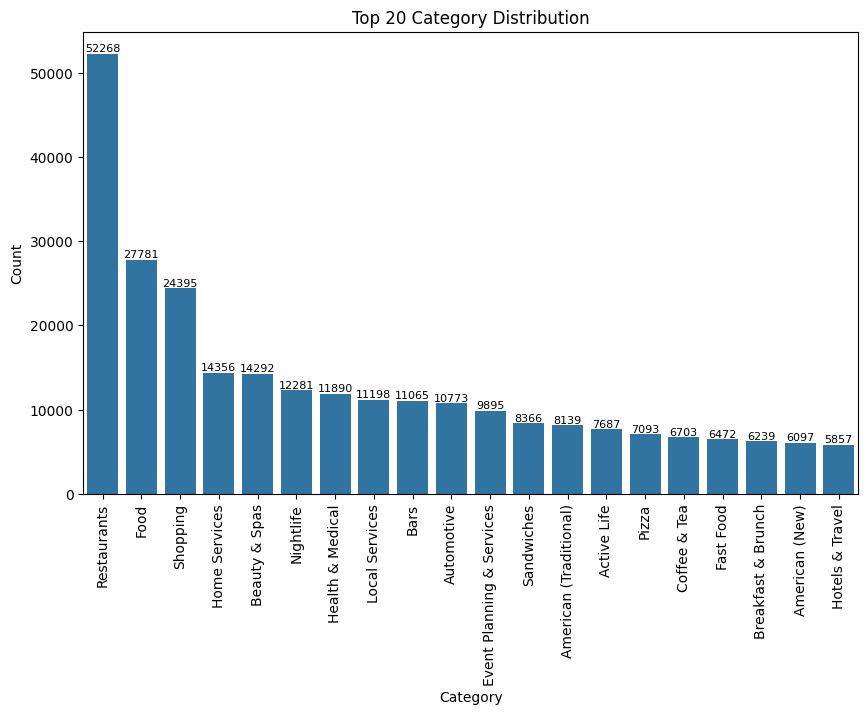

In [ ]:
# visulaization of top 20
category_counts_pd = top_20_categories.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='count', data=category_counts_pd)
# show count on top of each bar
for index, row in category_counts_pd.iterrows():
    plt.text(index, row['count'], str(row['count']), ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Top 20 Category Distribution')
plt.show()

del category_counts_pd # for efficiency

The bar chart shows the top 20 most frequent business categories in the Yelp dataset. **Restaurants** dominate the dataset, with 52,000+ entries.
Other common categories include **Food**, **Shopping**, **Home Services**, and **Beauty & Spas**, suggesting a strong presence of service-oriented businesses.
As we can see our dataset is biased. Most insights will likely center around restaurants and food-related services, which could influence sentiment analysis and business predictions.

### 4.2 Open vs Closed Businesses

In [ ]:
# now lets see the number of open and close businesses
business_counts = business_df.groupBy("is_open").count()
business_counts.show()

+-------+------+
|is_open| count|
+-------+------+
|      0|130128|
|      1|538464|
+-------+------+



<ipython-input-26-0fa644f3e736>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
<ipython-input-26-0fa644f3e736>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Closed", "Open"]) # renaming lables


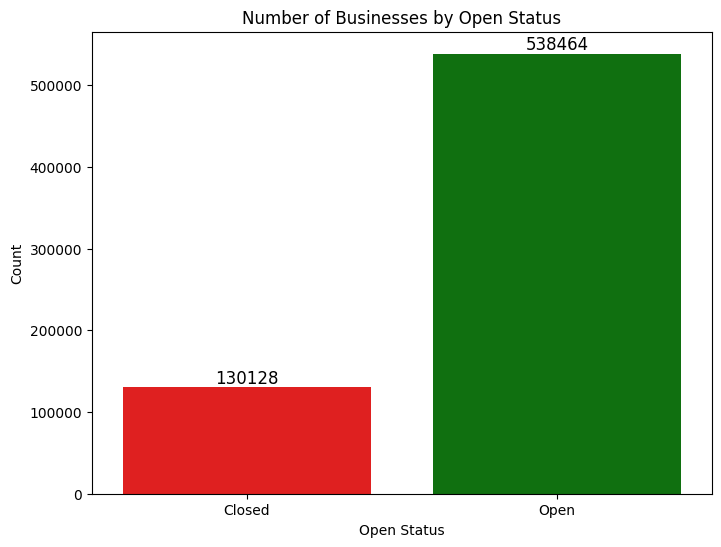

In [ ]:
# lets plot using pandas again
business_counts_pd = business_counts.toPandas()

plt.figure(figsize=(8, 6))
palette = {'0': "red", '1': "green"} # for coloring purpose
ax = sns.barplot(
    x="is_open",
    y="count",
    data=business_counts_pd,
    palette=palette
)
# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=12
    )
ax.set_xticklabels(["Closed", "Open"]) # renaming lables
plt.title("Number of Businesses by Open Status")
plt.xlabel("Open Status")
plt.ylabel("Count")
plt.show()

del business_counts_pd # for efficiency

This chart shows that the majority of businesses in the Yelp dataset are currently open (538,000+), while around **130,000 are closed**. We can use this information later to filter out closed businesses.

### 4.3 Map of Businesses

In [ ]:
# filter based on is_open
business_df_open = business_df.filter(business_df.is_open == 1)

# select only location columns
business = business_df_open.select("latitude", "longitude").toPandas()

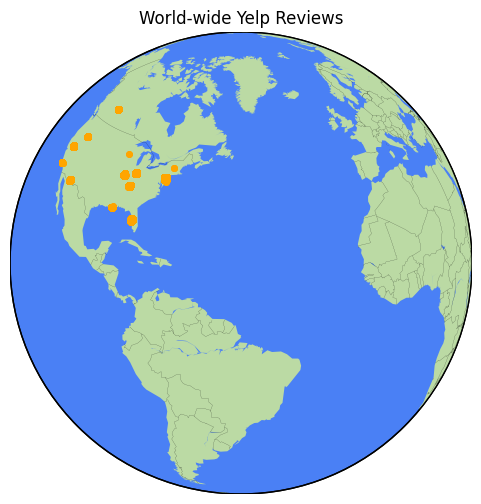

In [ ]:
## This code is taken from: https://www.kaggle.com/code/ksjpswaroop/yelp-ratings-eda
# basic basemap of the world
plt.figure(1, figsize=(15,6))
# use ortho projection for the globe type version
m1 = Basemap(projection='ortho',lat_0=20,lon_0=-50)

# hex codes from google maps color pallete = http://www.color-hex.com/color-palette/9261
#add continents
m1.fillcontinents(color='#bbdaa4',lake_color='#4a80f5')
# add the oceans
m1.drawmapboundary(fill_color='#4a80f5')
# Draw the boundaries of the countires
m1.drawcountries(linewidth=0.1, color="black")

#Add the scatter points to indicate the locations of the businesses
mxy = m1(business["longitude"].tolist(), business["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="orange", lw=3, alpha=1, zorder=5)
plt.title("World-wide Yelp Businesses")
plt.show()

del business # for efficiency

This map shows the geographic distribution of businesses, which are mainly concentrated in **North America**. The most insights from the dataset will reflect trends in the U.S. and Canada.

### 4.4 Cities Distribution

In [ ]:
# Get top 20 cities by business count
city_counts = business_df.groupBy("city").count().orderBy("count", ascending=False).limit(15)
city_counts_pd = city_counts.toPandas()

<ipython-input-30-7bc9ee842273>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_counts_pd, y="city", x="count", palette="viridis")


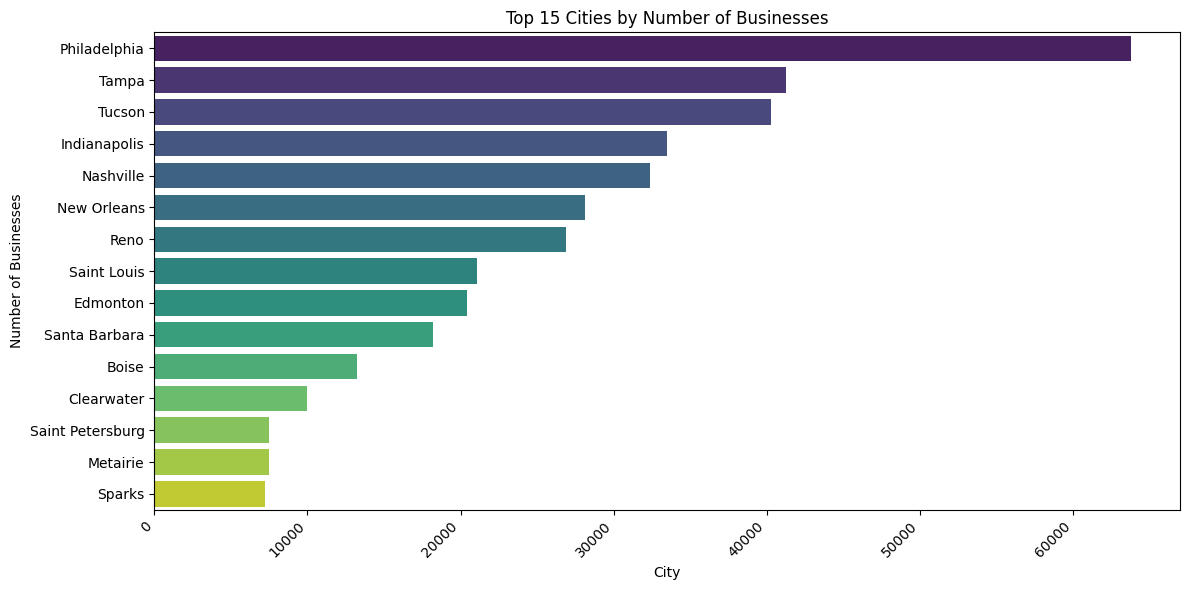

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=city_counts_pd, y="city", x="count", palette="viridis")
plt.title("Top 15 Cities by Number of Businesses")
plt.xlabel("City")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

del city_counts_pd # for efficiency

This chart displays the top 15 cities with the highest number of businesses. **Philadelphia** is the top one, followed by cities like **Tampa**, **Tucson**, and **Indianapolis**.

### 4.5 Review Count Distribution

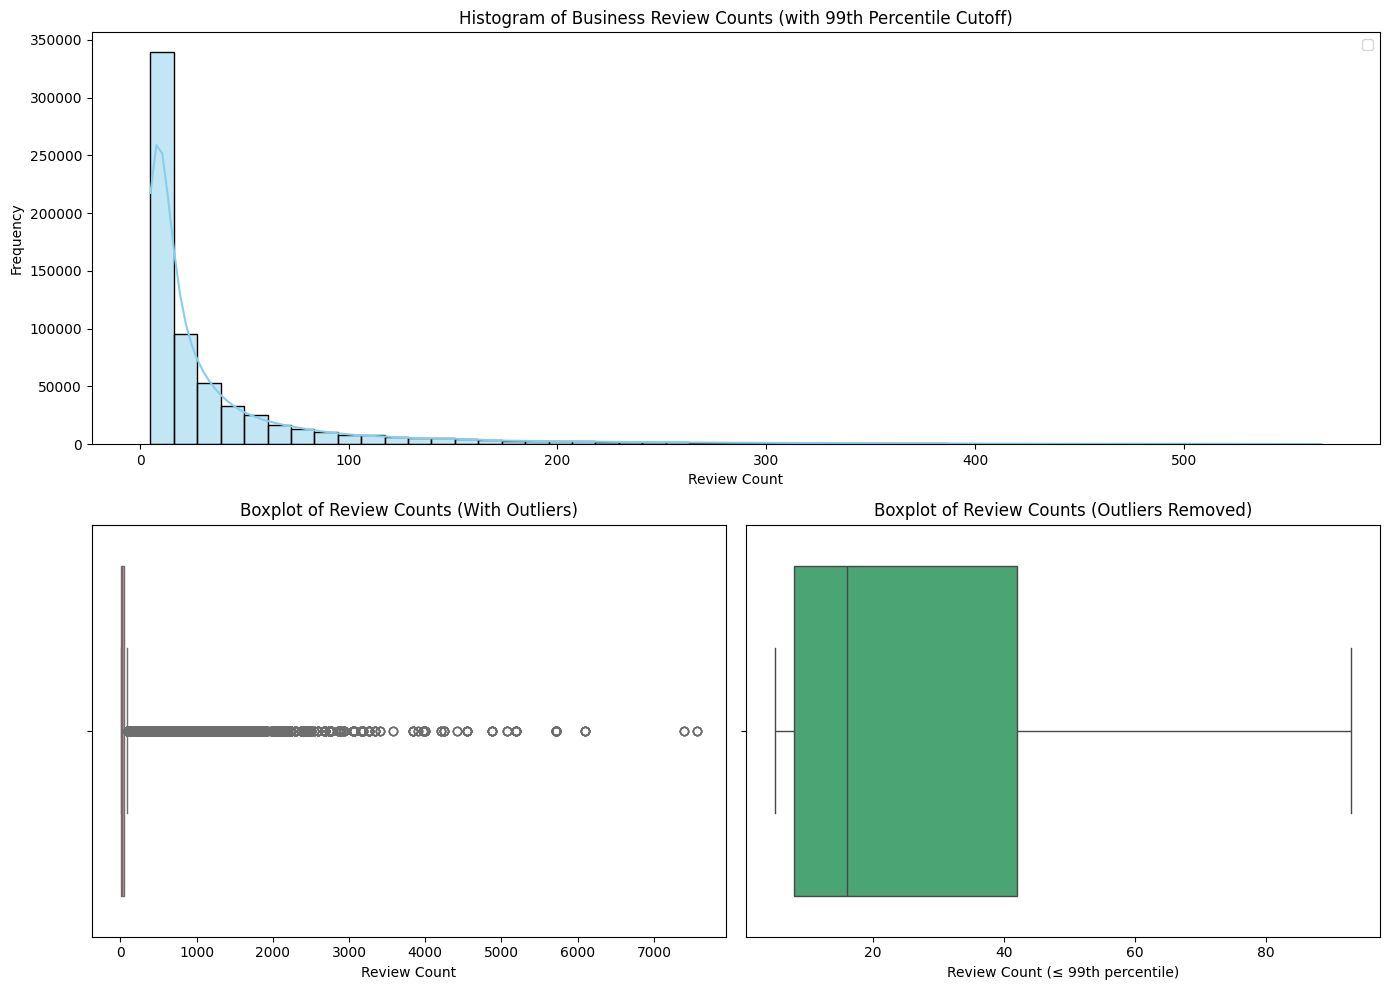

In [ ]:
review_counts_pd = business_df.select("review_count").toPandas()

# calculate 99th percentile cutoff (for clean visualization)
cutoff = review_counts_pd["review_count"].quantile(0.99)
filtered_pd = review_counts_pd[review_counts_pd["review_count"] <= cutoff]

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# histogram with cutoff
ax1 = fig.add_subplot(gs[0, :])
sns.histplot(filtered_pd["review_count"], bins=50, kde=True, color="skyblue", ax=ax1)
ax1.set_title("Histogram of Business Review Counts (with 99th Percentile Cutoff)")
ax1.set_xlabel("Review Count")
ax1.set_ylabel("Frequency")
ax1.legend()

# boxplot with all data
ax2 = fig.add_subplot(gs[1, 0])
sns.boxplot(x=review_counts_pd["review_count"], color="lightcoral", ax=ax2)
ax2.set_title("Boxplot of Review Counts (With Outliers)")
ax2.set_xlabel("Review Count")

# boxplot without outliers
ax3 = fig.add_subplot(gs[1, 1])
sns.boxplot(x=review_counts_pd["review_count"], color="mediumseagreen", ax=ax3, showfliers=False)
ax3.set_title("Boxplot of Review Counts (Outliers Removed)")
ax3.set_xlabel("Review Count")

plt.tight_layout()
plt.show()

del review_counts_pd, filtered_pd # for efficiency

These plots show the distribution of business review counts. The histogram and boxplots shows that our dataset is highly right skewed. Since most businesses have very few reviews, while a small number have extremely high counts (outliers). After not displaying outliers, the boxplot becomes more balanced, showing that typical businesses receive between 10-80 reviews.

### 4.6 Starts Distribution

<ipython-input-37-ff01b6d0a764>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stars_pd, x="stars", y="count", palette="Set1")


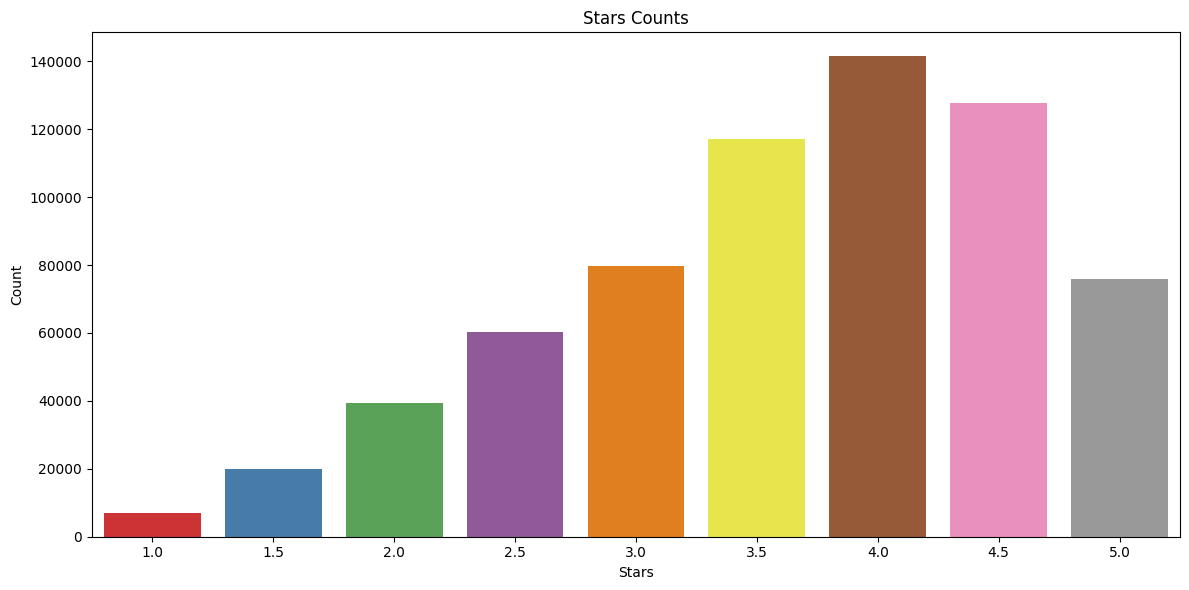

In [ ]:
# count the number of businesses under each star
stars_pd = business_df.select("stars").groupBy("stars").count().orderBy("stars").toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=stars_pd, x="stars", y="count", palette="Set1")
plt.title("Stars Counts")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

del stars_pd # for efficiency

This bar chart shows the distribution of average star ratings across businesses. Most businesses have ratings between **3.5 and 4.5**, with **4.0 stars being the most common**, indicating generally positive customer feedback. Very low ratings (1.0-2.0) are less frequent, suggesting either good service quality overall or potential bias in review behavior.

### 4.7 Top Businesses

In [ ]:
# This code is based on Bayesian Rating

# compute C by taking the average rating
C = business_df.select(avg("stars")).first()[0]

# compute m (minimum reviews to qualify — 95th percentile)
review_counts_pd = business_df.select("review_count").toPandas()
m = int(review_counts_pd["review_count"].quantile(0.95))

# filter qualified businesses that are above or equal m
qualified_df = business_df.filter(col("review_count") >= m)

# compute weighted rating in Spark
qualified_df = qualified_df.withColumn(
    "weighted_rating",
    (col("review_count") / (col("review_count") + lit(m))) * col("stars") +
    (lit(m) / (col("review_count") + lit(m))) * lit(C)
)

# select top businesses that have highest weighted rating
top_weighted_df = (
    qualified_df
    .select("name", "stars", "review_count", "weighted_rating")
    .orderBy(col("weighted_rating").desc())
    .dropDuplicates(["name"])
    .limit(20)
)

# convert to Pandas
top_weighted_pd = top_weighted_df.toPandas()

del review_counts_pd, qualified_df, top_weighted_df # for efficiency

<ipython-input-39-7bec7a16eb01>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_weighted_pd, y="name", x="weighted_rating", palette="crest")


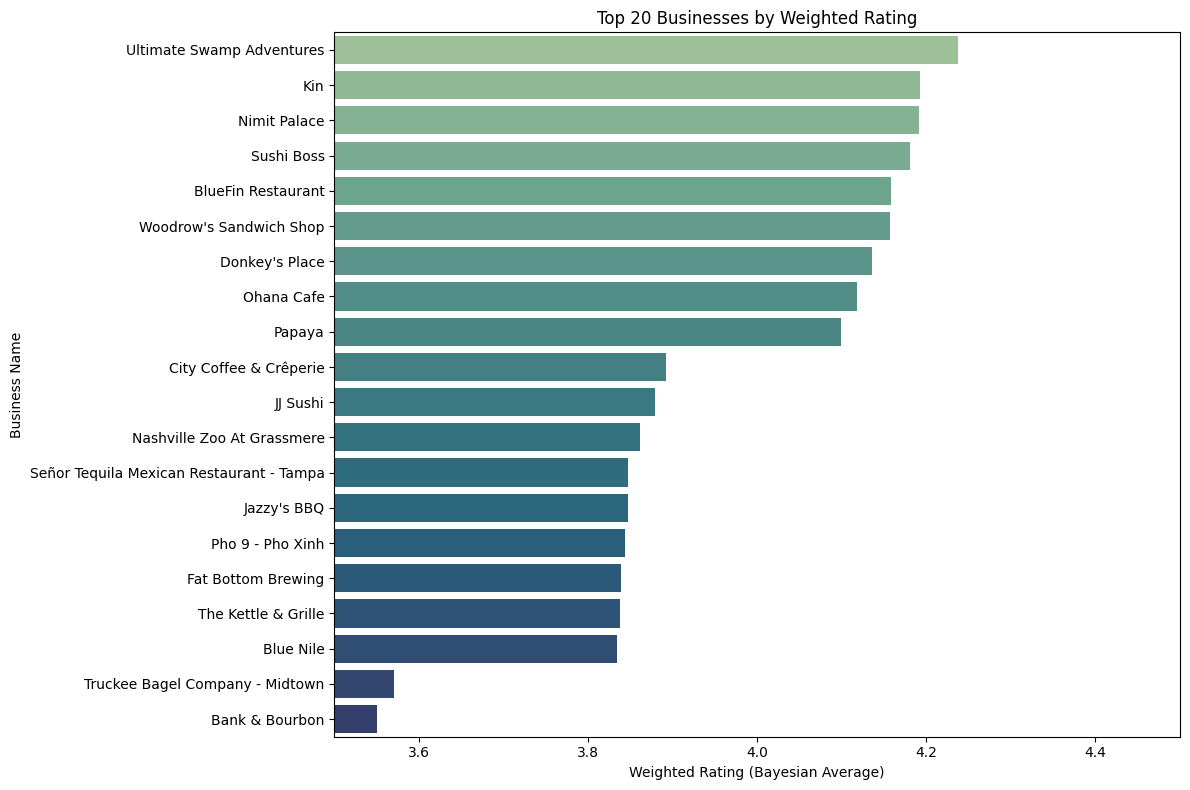

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top_weighted_pd, y="name", x="weighted_rating", palette="crest")
plt.title("Top 20 Businesses by Weighted Rating")
plt.xlabel("Weighted Rating (Bayesian Average)")
plt.ylabel("Business Name")
plt.xlim(3.5, 4.5)
plt.tight_layout()
plt.show()

del top_weighted_pd # for efficiency

This chart highlights the top 20 businesses ranked by their **Bayesian weighted rating**, which balances both the average rating and the number of reviews. It helps avoid bias from businesses with few but perfect scores. For example, **Ultimate Swamp Adventures** ranks highest, suggesting both high ratings and a strong review count.

## 5. Exploratory Data Analysis - Users

### 5.1 Review Count Distribution

In [ ]:
review_counts_user_pd = user_df.select("review_count").toPandas()

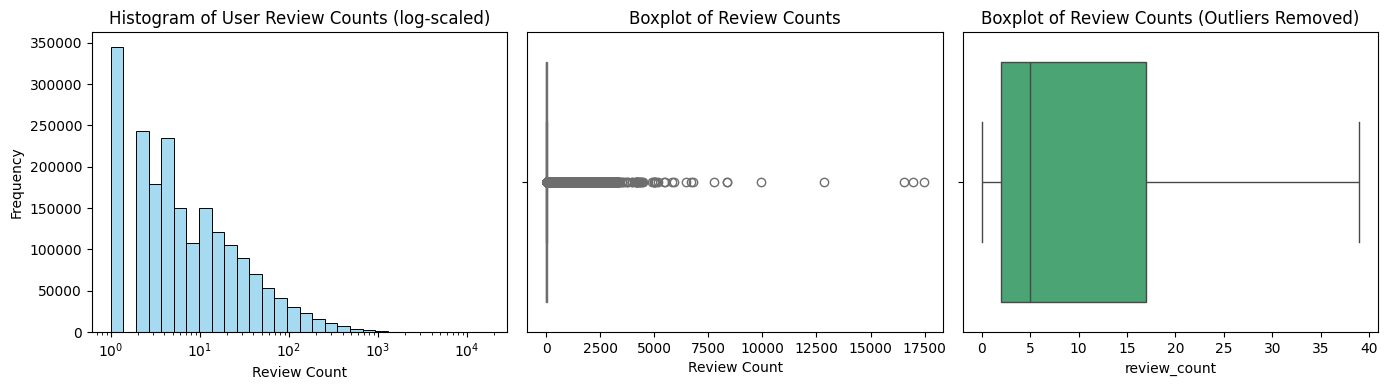

In [ ]:
# subplot for histogram and box plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# histogram (log scale)
sns.histplot(review_counts_user_pd["review_count"], bins=30, color="skyblue", ax=ax1, log_scale=True)
ax1.set_title("Histogram of User Review Counts (log-scaled)")
ax1.set_xlabel("Review Count")
ax1.set_ylabel("Frequency")

# boxplot
sns.boxplot(x=review_counts_user_pd["review_count"], color="lightcoral", ax=ax2)
ax2.set_title("Boxplot of Review Counts")
ax2.set_xlabel("Review Count")

# boxplot without outliers
sns.boxplot(x=review_counts_user_pd["review_count"], color="mediumseagreen", ax=ax3, showfliers=False)
ax3.set_title("Boxplot of Review Counts (Outliers Removed)")

plt.tight_layout()
plt.show()

del review_counts_user_pd # for efficiency

These plots analyze how many reviews each user has written. The log-scaled histogram shows that most users contribute only a few reviews, while a small number write thousands of reviews. The boxplots confirm this skew — outliers are extreme, but when not displayed, typical users have written between 1 and 40 reviews. This helps us understand user engagement levels.

### 5.3 Average Stars Distribution

In [ ]:
stars_user_pd = user_df.select("average_stars").toPandas()

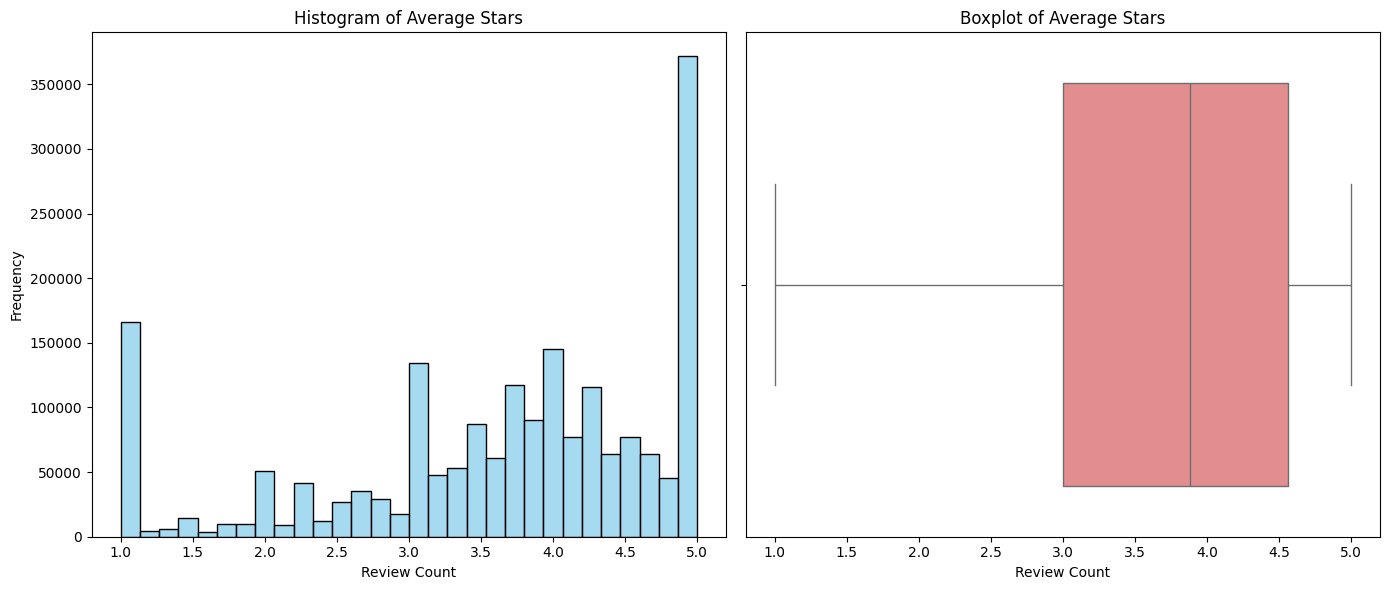

In [ ]:
# subplot for histogram and box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# histogram
sns.histplot(stars_user_pd["average_stars"], bins=30, color="skyblue", ax=ax1)
ax1.set_title("Histogram of Average Stars")
ax1.set_xlabel("Review Count")
ax1.set_ylabel("Frequency")

# boxplot
sns.boxplot(x=stars_user_pd["average_stars"], color="lightcoral", ax=ax2)
ax2.set_title("Boxplot of Average Stars")
ax2.set_xlabel("Review Count")

plt.tight_layout()
plt.show()

del stars_user_pd # for efficiency

This plot shows how users rate businesses on average. Most users tend to give very high (5.0) or very low (1.0) ratings, suggesting polarized opinions. The boxplot confirms a central tendency between 3.5 and 4.5 stars, indicating that users generally lean toward positive reviews.

### 5.4 Number of Friends per User Distribution

In [ ]:
# see the friends column
#user_df.select("friends").show(5, False)

# this is made the notebook to look like a mess in the github so i commented it
# however it looks something like this:

# <user_id>, <user_id>, ...

In [ ]:
# count the number of friends for each user by splitting by "," then explode
user_df = user_df.withColumn("num_friends", size(split(col("friends"), ",")))
num_friends_pd = user_df.select("num_friends").toPandas()

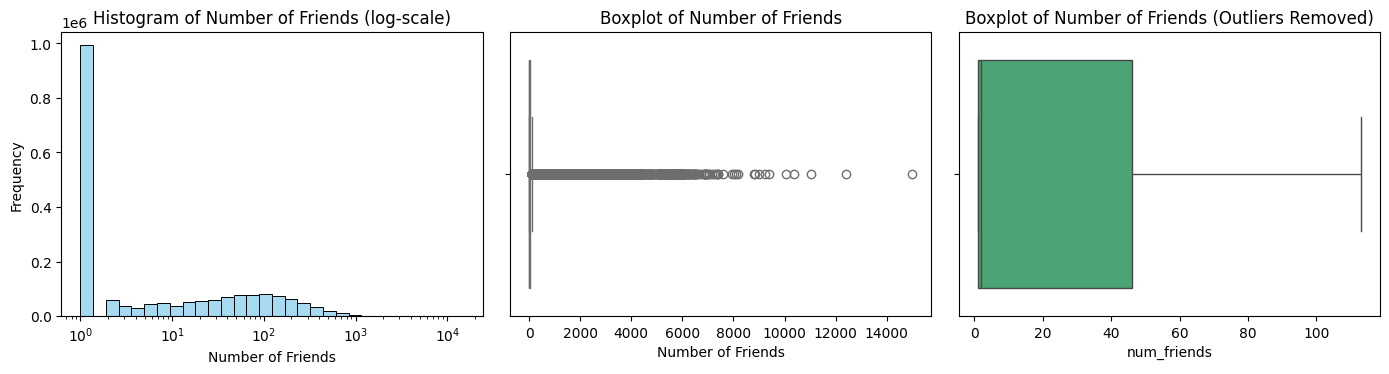

In [ ]:
# plot the distribution and box plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# histogram (log-scaled)
sns.histplot(num_friends_pd["num_friends"], bins=30, color="skyblue", ax=ax1, log_scale=True)
ax1.set_title("Histogram of Number of Friends (log-scale)")
ax1.set_xlabel("Number of Friends")
ax1.set_ylabel("Frequency")

# boxplot
sns.boxplot(x=num_friends_pd["num_friends"], color="lightcoral", ax=ax2)
ax2.set_title("Boxplot of Number of Friends")
ax2.set_xlabel("Number of Friends")

# boxplot without outliers
sns.boxplot(x=num_friends_pd["num_friends"], color="mediumseagreen", ax=ax3, showfliers=False)
ax3.set_title("Boxplot of Number of Friends (Outliers Removed)")

plt.tight_layout()
plt.show()

del num_friends_pd # for efficiency

These plots show the distribution of how many friends each user has. Most users have very few friends, as shown by the spike near 1 in the log-scale histogram. The boxplots reveal many extreme outliers, but once removed, the typical user has between **1 and 100 friends**, suggesting a moderately connected user base on Yelp.

### 5.5 Correlation heatmap

In [ ]:
# select all numerical columns for correlation
numeric_cols = [
    "average_stars", "compliment_cool", "compliment_cute", "compliment_funny",
    "compliment_hot", "compliment_list", "compliment_more", "compliment_note",
    "compliment_photos", "compliment_plain", "compliment_profile", "compliment_writer",
    "cool", "fans", "funny", "review_count", "useful", "num_friends"
]

# Create empty matrix
corr_matrix = {}

# Compute pairwise correlations (since full correaltion is not provided through spark)
for i in range(len(numeric_cols)):
    col1 = numeric_cols[i]
    corr_matrix[col1] = {}
    # skip all previous
    for j in range(i+1, len(numeric_cols)):
        print(f"Computing correlation between {col1} and {numeric_cols[j]}")
        col2 = numeric_cols[j]
        corr = user_df.stat.corr(col1, col2)
        corr_matrix[col1][col2] = corr

Computing correlation between average_stars and compliment_cool
Computing correlation between average_stars and compliment_cute
Computing correlation between average_stars and compliment_funny
Computing correlation between average_stars and compliment_hot
Computing correlation between average_stars and compliment_list
Computing correlation between average_stars and compliment_more
Computing correlation between average_stars and compliment_note
Computing correlation between average_stars and compliment_photos
Computing correlation between average_stars and compliment_plain
Computing correlation between average_stars and compliment_profile
Computing correlation between average_stars and compliment_writer
Computing correlation between average_stars and cool
Computing correlation between average_stars and fans
Computing correlation between average_stars and funny
Computing correlation between average_stars and review_count
Computing correlation between average_stars and useful
Computing co

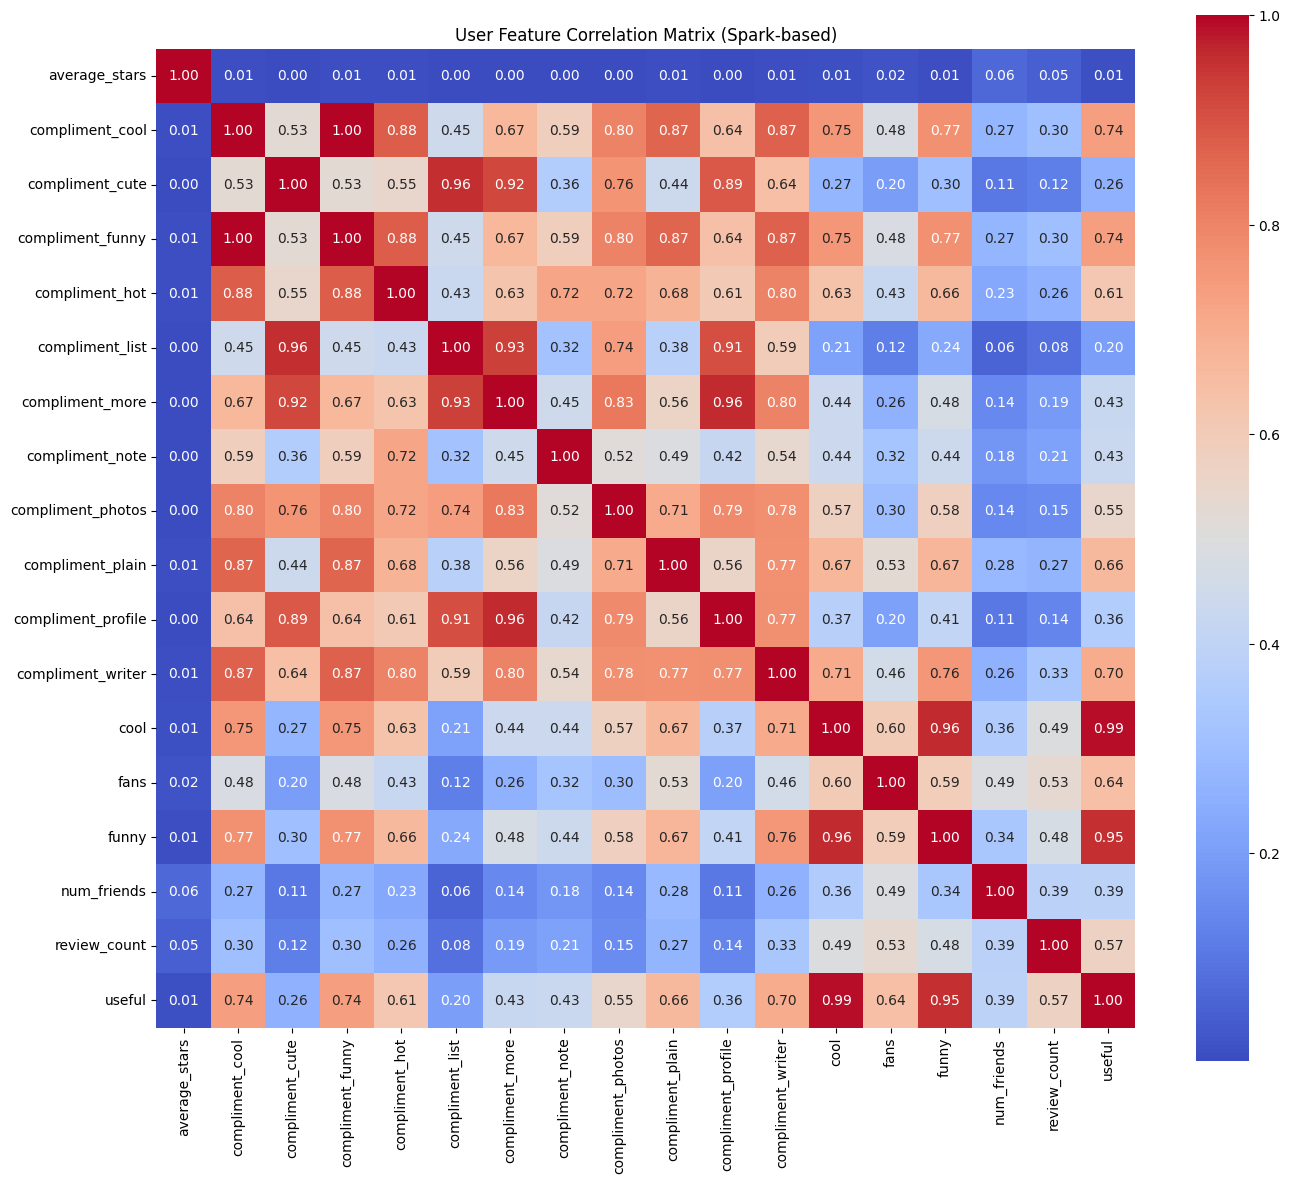

In [ ]:
# fill in symmetric values
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        col1 = numeric_cols[i]
        col2 = numeric_cols[j]
        corr = corr_matrix[col1][col2]
        # set symmetric entries
        corr_matrix.setdefault(col2, {})[col1] = corr
    # set diagonal
    corr_matrix[col1][col1] = 1.0

# final diagonal for last col
corr_matrix[numeric_cols[-1]][numeric_cols[-1]] = 1.0

# create corr DataFrame
corr_df = pd.DataFrame(corr_matrix).sort_index(axis=0).sort_index(axis=1)

# plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("User Feature Correlation Matrix (Spark-based)")
plt.tight_layout()
plt.show()

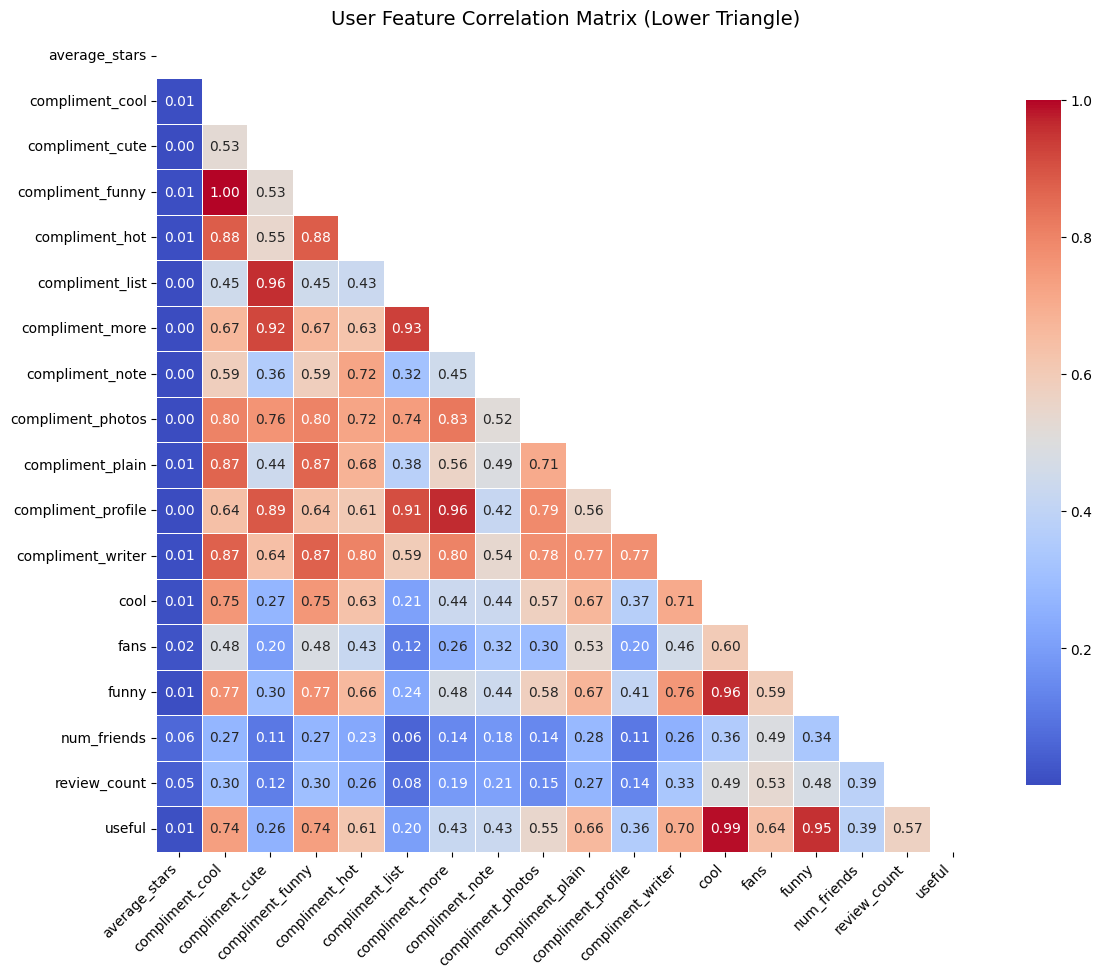

In [ ]:
import numpy as np

# Compute mask for upper triangle (to show unrepeated numbers)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Plot heatmap with mask
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_df,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("User Feature Correlation Matrix (Lower Triangle)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


This correlation matrix shows relationships between user features. Strong positive correlations appear among **compliment types** (e.g., `compliment_profile`, `compliment_list`, `compliment_more`), suggesting that users who receive one type of compliment tend to receive others too. Interestingly, `average_stars` has very **weak** correlations with other features, meaning **users' average ratings are not influenced by their social engagement or popularity**.

### 5.6 Number of Elite Users per Year

In [ ]:
elite_years_pd = (
    user_df
    .filter(col("elite") != "")  # ignore users with empty elite
    .withColumn("elite_year", explode(split("elite", ","))) # split based on ',' and explode
    .groupBy("elite_year").count() # the # of users for each year
    .orderBy("elite_year") # order it ascendingly
).toPandas()

<ipython-input-103-b88b7a846031>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=elite_years_pd, x="elite_year", y="count", palette="magma")


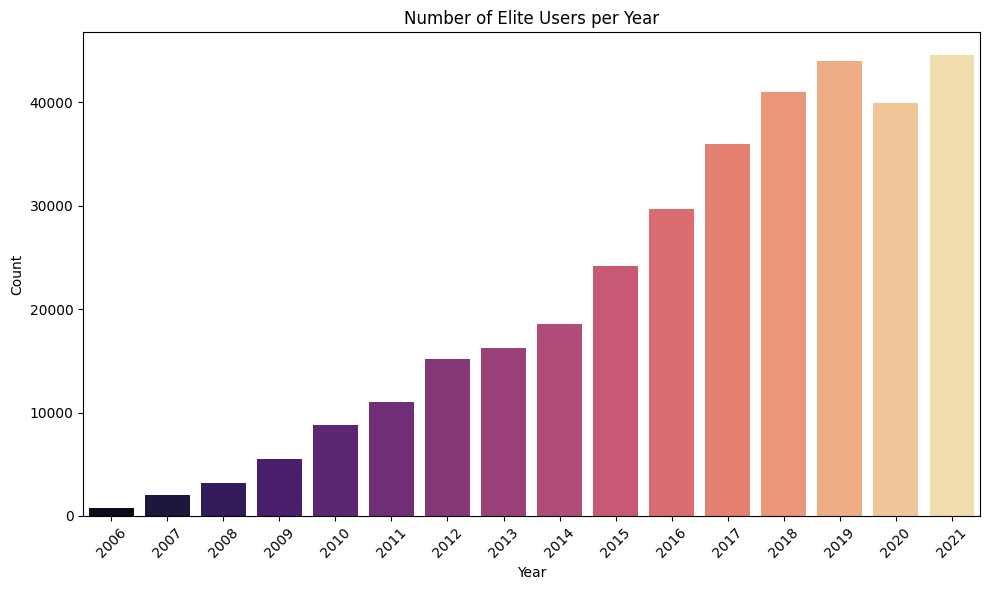

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=elite_years_pd, x="elite_year", y="count", palette="magma")
plt.title("Number of Elite Users per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

del elite_years_pd # for efficiency

This bar chart shows the number of Yelp elite users by year. The steady increase from 2006 to 2021 reflects Yelp's growing user engagement and community recognition over time. However, we can see that there is a noticable decrease in **2020**. This most likely reflects the impact of the COVID-19 pandemic. With many businesses closed and fewer people dining out or engaging in local services, user activity on Yelp may have declined, leading to fewer users meeting the criteria for elite status that year.

### 5.7 Top 20 Users by fans

In [ ]:
top_fans_pd = user_df.select("name", "fans").orderBy(col("fans").desc()).limit(20).toPandas()

<ipython-input-78-b92fade8fb1b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_fans_pd, y="name", x="fans", palette="coolwarm")


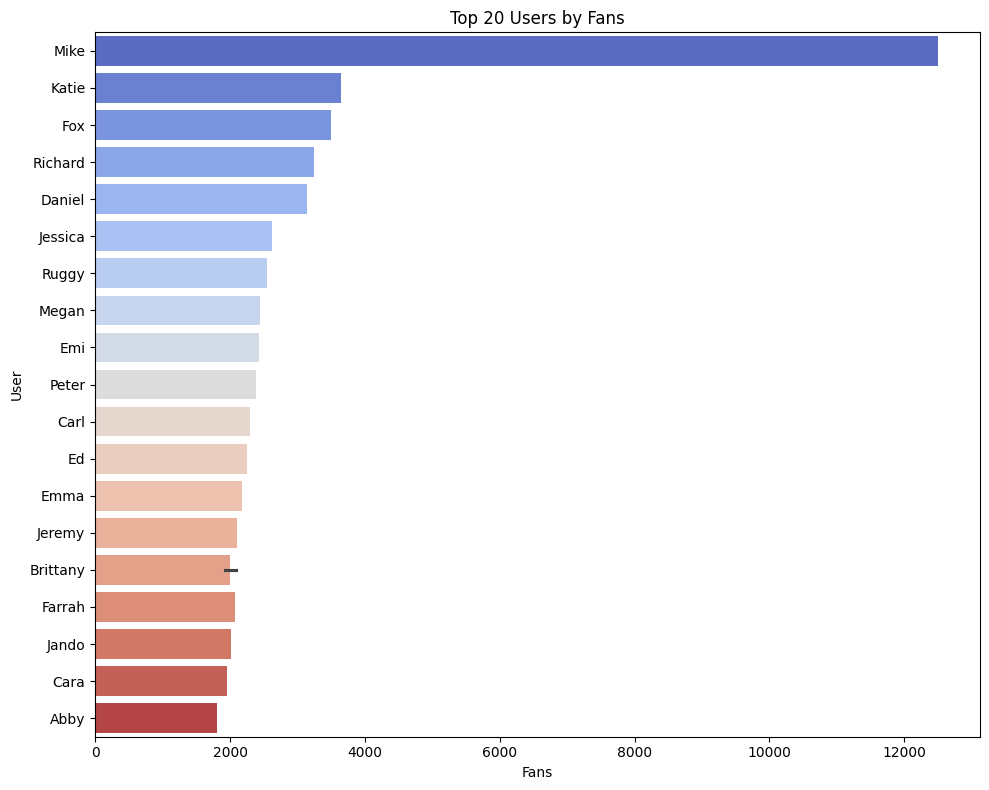

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(data=top_fans_pd, y="name", x="fans", palette="coolwarm")
plt.title("Top 20 Users by Fans")
plt.xlabel("Fans")
plt.ylabel("User")
plt.tight_layout()
plt.show()

del top_fans_pd # for efficiency

This chart shows the top 20 Yelp users ranked by number of fans. **Mike** stands out with a significantly higher fan count than all others, meaning a highly influential presence on the platform. These users likely produce trusted or engaging content, making them ideal targets for influencer-based strategies or recommendation system tuning.

### 5.8 review_count vs. average_stars

In [ ]:
review_stars_pd = user_df.select("review_count", "average_stars").limit(50000).toPandas()

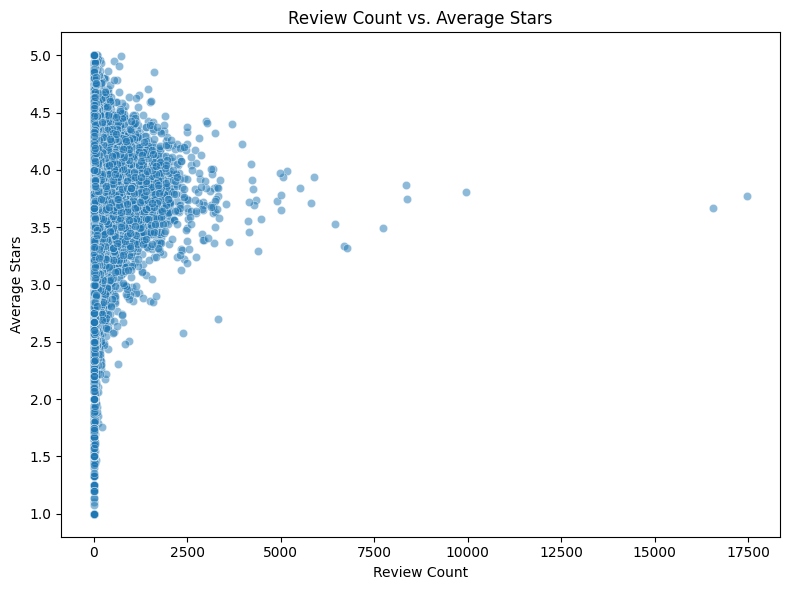

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=review_stars_pd, x="review_count", y="average_stars", alpha=0.5)
plt.title("Review Count vs. Average Stars")
plt.xlabel("Review Count")
plt.ylabel("Average Stars")
plt.tight_layout()
plt.show()

del review_stars_pd # for efficiency

This scatter plot shows the relationship between a user's review count and their average rating. Most users have written fewer than 2,500 reviews and tend to give average ratings around 3-4 stars. There's no strong correlation, suggesting that writing more reviews doesn't necessarily affect the positivity or negativity of a user's ratings.

### 5.9 new users by year

In [ ]:
yearly_users_pd = user_df.groupBy("yelping_year").count().orderBy("yelping_year").toPandas()

<ipython-input-83-73d60f377535>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_users_pd, x="yelping_year", y="count", palette="Blues_d")


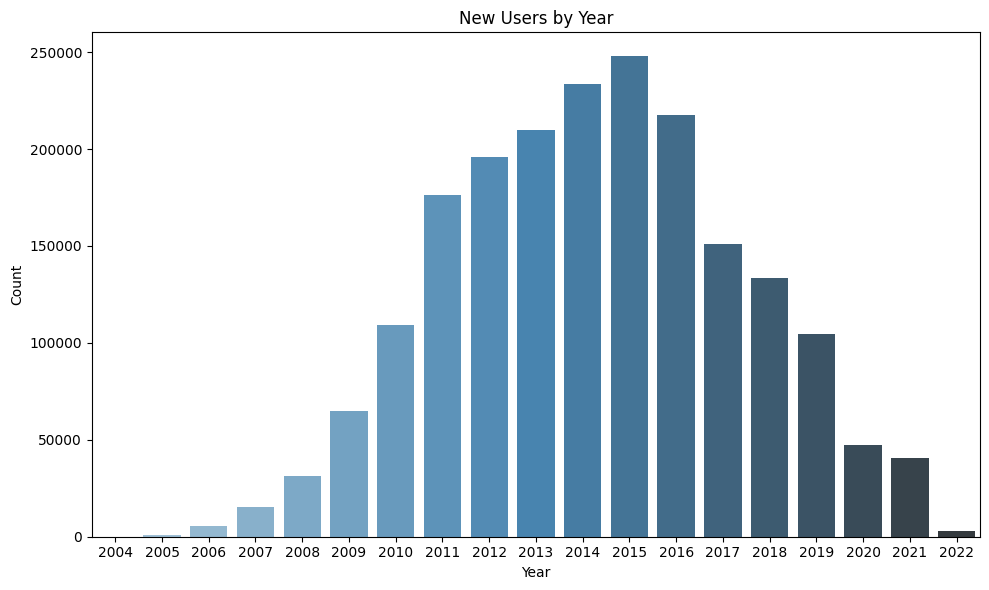

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=yearly_users_pd, x="yelping_year", y="count", palette="Blues_d")
plt.title("New Users by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

del yearly_users_pd # for efficiency

This bar chart shows the number of new Yelp users by year. User growth peaked in **2015**, followed by a steady decline. The sharp drop after **2019** likely reflects the impact of the COVID-19 pandemic, which reduced consumer activity and interest in reviewing local businesses.

### 5.10 Distribution of `funny`, `cool`, `useful`

In [ ]:
user_stats_pd = user_df.select("funny", "cool", "useful").toPandas()

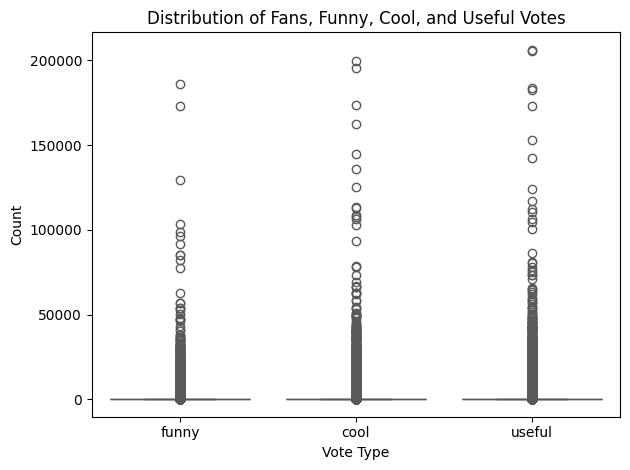

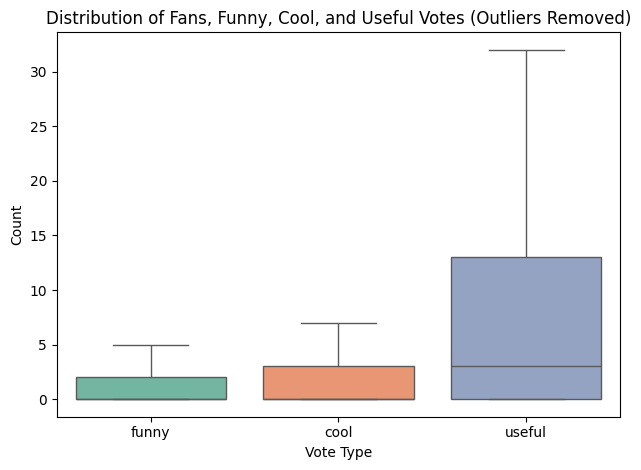

In [ ]:
# box plot
sns.boxplot(data=user_stats_pd, palette="Set2")
plt.title("Distribution of Fans, Funny, Cool, and Useful Votes")
plt.xlabel("Vote Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# without outliers
sns.boxplot(data=user_stats_pd, palette="Set2", showfliers=False)
plt.title("Distribution of Fans, Funny, Cool, and Useful Votes (Outliers Removed)")
plt.xlabel("Vote Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

del user_stats_pd # for efficiency

These boxplots show the distribution of user votes — **funny**, **cool**, and **useful**. The first plot (with outliers) reveals that a small number of users received extremely high counts in all categories. The second plot (with outliers removed) shows that most users receive only a few votes, especially for funny and cool, while useful votes are more common, indicating users tend to value helpful reviews the most.